# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Hasbi Abdullah]
- **Email:** [hasbiabdullah75571@gmail.com]
- **ID Dicoding:** [m198d5y0743]

## Import Semua Packages/Library yang Digunakan

In [15]:
!pip install split-folders
!pip install tensorflowjs

# Library umum
import os
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import splitfolders
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Libraries untuk pemrosesan data gambar
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TFSMLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from google.colab import drive

## Data Preparation

### Data Loading

In [49]:
local_zip = '/content/Shoe vs Sandal vs Boot.zip'
extracted_base = '/tmp/Shoe vs Sandal vs Boot Dataset'

if os.path.exists(local_zip) and not os.path.exists(extracted_base):
    with zipfile.ZipFile(local_zip, 'r') as z:
        z.extractall('/tmp')
    print('Extracted zip to /tmp')

Extracted zip to /tmp


In [50]:
output_dir = '/tmp/shoes_split'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

splitfolders.ratio(extracted_base, output=output_dir, seed=42, ratio=(.7, .15, .15))

train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

Copying files: 15000 files [00:02, 7143.03 files/s]


In [52]:
os.listdir(train_dir)

['Shoe', 'Sandal', 'Boot']

In [53]:
os.listdir(validation_dir)

['Shoe', 'Sandal', 'Boot']

In [54]:
os.listdir(test_dir)

['Shoe', 'Sandal', 'Boot']

### Data preprocessing

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

#### Split Dataset

In [56]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

# data validasi dari local
validation_from_validation_dir_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

Found 8400 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


## Modelling

In [57]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nAkurasi dan validasi akurasi telah mencapai >= 95%!")
            self.model.stop_training = True

# Define callbacks for early stopping and model checkpointing
callbacks = [
    MyCallback(), # Custom callback for 95% accuracy
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint(
        'best_model.keras', # Changed from .h5 to .keras
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='min'
    )
]

In [61]:
# Fungsi pembantu untuk mengonversi ImageDataGenerator ke tf.data.Dataset dengan .repeat()
def generator_to_tf_dataset(generator_instance, steps_per_epoch):
    def gen():
        for _ in range(steps_per_epoch):
            yield next(generator_instance)

    # Dapatkan signature output dari satu batch untuk tf.data.Dataset
    sample_batch = next(generator_instance)
    # Reset generator agar dapat digunakan dari awal oleh dataset tf.data
    generator_instance.reset()

    # Set batch dimension to None to allow variable batch sizes
    output_signature = (
        tf.TensorSpec(shape=(None, *sample_batch[0].shape[1:]), dtype=sample_batch[0].dtype),
        tf.TensorSpec(shape=(None, *sample_batch[1].shape[1:]), dtype=sample_batch[1].dtype)
    )

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )
    return dataset.repeat() # Pastikan dataset berulang tanpa batas

# Hitung steps_per_epoch untuk pelatihan, validasi, dan pengujian
train_ds_steps = train_generator.samples // train_generator.batch_size
validation_ds_steps = validation_from_validation_dir_generator.samples // validation_from_validation_dir_generator.batch_size
test_ds_steps = test_generator.samples // test_generator.batch_size

# Konversi generator ke tf.data.Dataset
train_dataset = generator_to_tf_dataset(train_generator, train_ds_steps)
validation_dataset = generator_to_tf_dataset(validation_from_validation_dir_generator, validation_ds_steps)
test_dataset = generator_to_tf_dataset(test_generator, test_ds_steps)

print(f"train_dataset created with {train_ds_steps} steps per epoch")
print(f"validation_dataset created with {validation_ds_steps} steps per epoch")
print(f"test_dataset created with {test_ds_steps} steps per epoch")

train_dataset created with 131 steps per epoch
validation_dataset created with 35 steps per epoch
test_dataset created with 35 steps per epoch


In [62]:
# Train the model using the new tf.data.Dataset objects
history = model.fit(
    train_dataset,
    steps_per_epoch=train_ds_steps,
    epochs=50, # Start with a reasonable number, early stopping will prevent overfitting
    validation_data=validation_dataset,
    validation_steps=validation_ds_steps,
    callbacks=callbacks
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4798 - loss: 1.3265
Epoch 1: val_loss improved from inf to 0.54885, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.4805 - loss: 1.3237 - val_accuracy: 0.7777 - val_loss: 0.5488
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6831 - loss: 0.7090
Epoch 2: val_loss did not improve from 0.54885
131/131 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.6833 - loss: 0.7086 - val_accuracy: 0.7339 - val_loss: 0.5499
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7541 - loss: 0.5718
Epoch 3: val_loss improved from 0.54885 to 0.39134, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.7542 - loss: 0.5717 - val_accuracy: 0.8433 - val_loss: 0.3913
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7865 - loss: 0.5116
Epoch 4: val_loss improved from 0.39134 to 0.30956, saving model to best_model.keras
131/131 

In [63]:
# EVALUATE on test set
test_generator.reset()
loss, acc = model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 - 30s - 830ms/step - accuracy: 0.9756 - loss: 0.0811
Test Loss: 0.0811 | Test Accuracy: 0.9756


36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


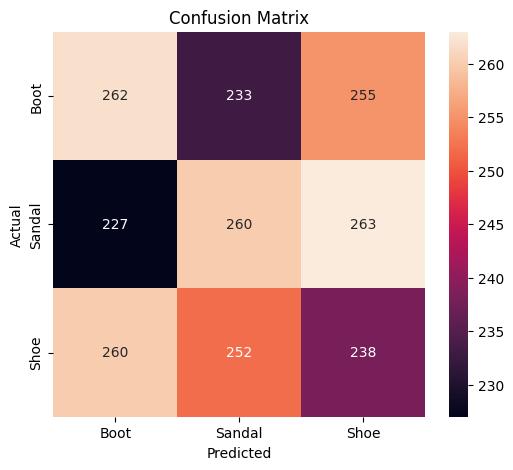

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probabilities = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Get class labels
labels = list(test_generator.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

In [66]:
# Save keras .keras

model.save('model.keras')

print('Saved model.keras')

Saved model.keras


## Evaluasi dan Visualisasi

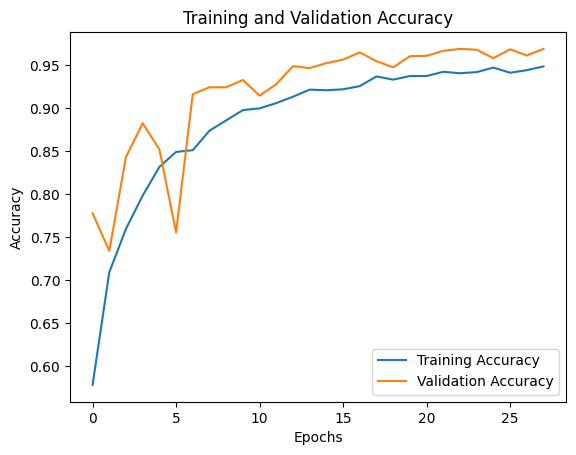

In [67]:
plt.plot(history.history['accuracy'], label='Training Accuracy') # Plot akurasi training
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Plot akurasi validasi
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

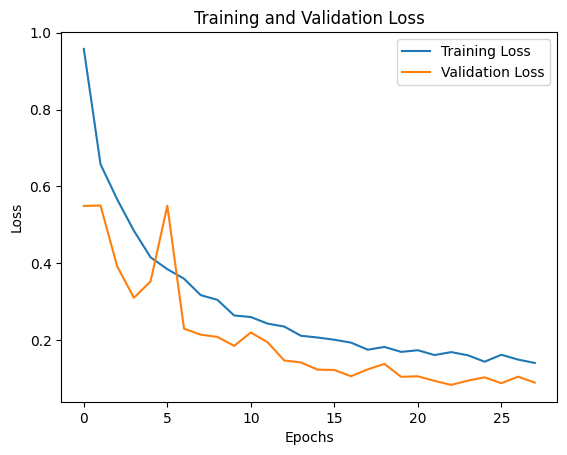

In [68]:
plt.plot(history.history['loss'], label='Training Loss') # Plot loss training
plt.plot(history.history['val_loss'], label='Validation Loss') # Plot loss validasi
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [69]:
# saved model
export_dir = 'saved_model/'
model.export(export_dir) # Menggunakan model.export() untuk Keras 3.x

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133925164903568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133927825117968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164907024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164902032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164906256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164905104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164901264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164901648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925164902224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133925161747280: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [70]:
# TFlite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

76144804

In [71]:
# TFJS
# Mengonversi SavedModel ke TensorFlow.js
tfjs.converters.convert_tf_saved_model(export_dir, 'model_tfjs')

## Inference (Optional)

Saving shoe.jpg to shoe.jpg

Gambar: shoe.jpg


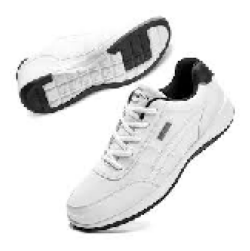

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediksi: Shoe
Confidence: 99.89%


In [74]:
from google.colab import files

# Mapping index → class name
# Use the labels from the trained generator for correct class names
inv_map = {v: k for k, v in train_generator.class_indices.items()}

uploaded = files.upload()

for fn in uploaded.keys():

    print(f"\nGambar: {fn}")

    # Load & tampilkan gambar
    img = image.load_img(fn, target_size=(150,150))
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0

    # Prediksi
    pred = model.predict(x)[0]
    class_idx = np.argmax(pred)
    class_name = inv_map[class_idx]
    confidence = pred[class_idx] * 100

    print(f"Prediksi: {class_name}")
    print(f"Confidence: {confidence:.2f}%")

In [75]:
import pkg_resources
import sys

def generate_requirements_file(output_file='requirements.txt'):
    installed_packages = pkg_resources.working_set
    packages_list = sorted([f'{i.key}=={i.version}' for i in installed_packages])

    with open(output_file, 'w') as f:
        for package in packages_list:
            f.write(package + '\n')
    print(f'Generated {output_file} with {len(packages_list)} packages.')

generate_requirements_file()

Generated requirements.txt with 715 packages.


In [76]:
with open('label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')
print('File label.txt berhasil dibuat.')

File label.txt berhasil dibuat.
